In [5]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# vehicle parameters:
params = {'gg radius': 1,
          't1 radius': 50,
          'mass': 300,
          'tire friction coeff': 1,
          'tire radius': 0.254,
          'drive ratio': 4,
          'drag coeff': 0.8,
          'downforce coeff': 0,
          'frontal area': 1,
          'drivetrain eff': 0.9
          }

# track parameters:
track = {'straight': 500,
         'turn 1': 3.14 * params['t1 radius']}

# constants:
pi = 3.14
g = 9.81 # m/s^2 accel due to gravity
rho = 1.225 # kg/m^3, air density

mtc = pd.read_csv('motor_torque_curve.csv')
mtc.head()

,RPM,torque
0,0.669973,230.253555
1,50.662053,230.219731
2,157.921821,230.219731
3,265.181590,230.219731
4,372.441359,230.219731


Below, I drew the J track shape.

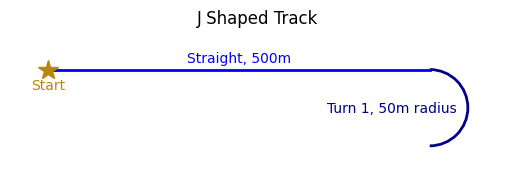

In [ ]:
from matplotlib.patches import Arc
fig, ax = plt.subplots()

# Straight, 500m
ax.plot([0, 500], [100, 100], linewidth=2, color='blue')
# 180 deg turn on the right, 50m radius
arc = Arc((500, 50), width=100, height=100, theta1=270, theta2=90, linewidth=2, color='darkblue')
ax.add_patch(arc)

ax.set_aspect("equal")
ax.plot(0, 100, marker='*', color='darkgoldenrod', markersize=15, label='Start')
plt.xlim(-50,600)
plt.ylim(-50,150)
plt.text(0, 75, "Start", fontsize=10, ha='center', color='darkgoldenrod')
plt.text(250, 110, "Straight, 500m", fontsize=10, ha='center', color='blue')
plt.text(450, 50, "Turn 1, 50m radius", fontsize=10, ha='center', va='center', color='darkblue')
plt.title("J Shaped Track")
plt.axis('off')
plt.show()

$m$: vehicle mass including driver \
$\mu$: tire friction coefficient \
$r$: tire radius \
$G$: drive ratio \
$\eta$: drivetrain efficiency \
$C_d$: drag coefficient \
$A$: frontal area

---

$ F_{actual} = \min(F_{applied}, F_{traction}) $ 

$ F_{traction} = \mu F_n = \mu mg $ 

$ F_{applied} = F_{motor} - F_{resistance} $ 

$ F_{motor} = \frac{\tau_{engine} G \eta}{r} $ 

we get $\tau_{engine}$ from the motor torque curve (RPM vs torque)

calculate $ RPM = \frac{60Gv}{2\pi r}$ then map it to the MTC for $\tau_{engine}$ using linear interpolation

$ F_{resistance} = F_{drag} = \frac{1}{2} \rho C_d A v^2 $

---

$ \tau = Fr $ 

$ v = \omega r $ 






torque over time graph

force actual over time graph

In [ ]:
def simulate(mesh_size):
    # Step 1: Mesh the track
    sections = [list(track.keys())[0]] + [section for section, length in track.items() for _ in range(int(np.ceil(length/mesh_size)))]
    x = np.array([0])
    for length in track.values():
        start_of_segment = x[-1]
        x = np.append(x, np.arange(start_of_segment+mesh_size, start_of_segment+length+1, mesh_size))
        if x[-1] < start_of_segment+length:
            x = np.append(x, start_of_segment+length)
    dx = np.append(np.array([0]), x[1:] - x[:-1])
    r = [0 if section == 'straight' else params['t1 radius'] for section in sections]
    data = pd.DataFrame({'section': sections, 'dx': dx, 'x': x, 'r': r})

    # Step 2: Consider the apex to be at the radius local minima.
    # Step 3: Fill in the apex speeds. v = sqrt(a_y * R), where a_y = gg_radius * g
    data['AT1 speed'] = data['DT1 speed'] = np.sqrt(params['gg radius'] * g * data['r'])

    # Step 4: Fill in the speed on the straight when accelerating
    # v_i+1 = sqrt(v_i^2 + 2 * a * dx_i+1)
    at1_v_prev = 0
    for i, segment in data.iterrows():
        if segment['section'] == 'straight':
            at1_v_prev = np.sqrt(at1_v_prev**2 + 2 * params['gg radius'] * g * segment['dx'])
            data.loc[i, 'AT1 speed'] = at1_v_prev

    # Step 5: Fill in the speed when decelerating
    # v_i-1 = sqrt(v_i^2 + 2 * a * dx_i)
    dt1_v_next = data[data['section'] == 'turn 1']['DT1 speed'].iloc[-1]
    for i in range(len(data)-1, -1, -1):
        segment = data.iloc[i]
        if segment['section'] == 'straight':
            dt1_v_next = np.sqrt(dt1_v_next**2 + 2 * params['gg radius'] * g * segment['dx'])
            data.loc[i, 'DT1 speed'] = dt1_v_next
    
    # Step 6: Final speed curve
    data['final speed'] = np.minimum(data['AT1 speed'], data['DT1 speed'])

    # Step 7: Calculate lap time
    data.loc[1:, 'time'] = data.loc[1:, 'dx'] / data.loc[1:, 'final speed']
    data.loc[0, 'time'] = 0

    # extra data!!!!
    
    # force due to traction = coeff of friction * m * g
    data['F_traction'] = params['tire friction coeff'] * params['mass'] * g

    # RPM = v / (2 * pi * tire radius) * 60
    # engine torque corresponds to RPM
    # force motor = engine_torque * drive ratio * drivetrain eff / tire radius
    #data['F_motor'] = 


    return data

def lap_time(mesh_size):
    return simulate(mesh_size)['time'].sum()

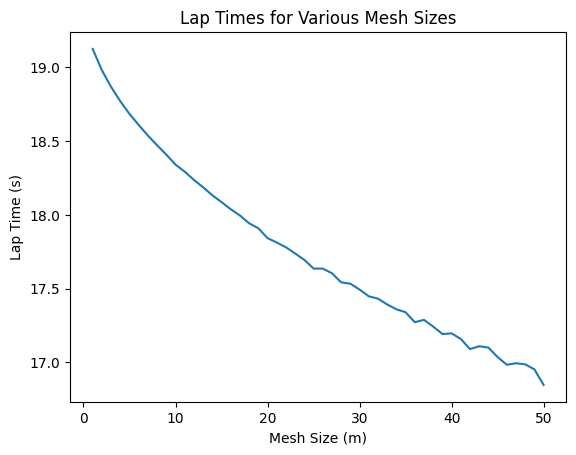

In [196]:
mesh_sizes = np.arange(1, 51)
trial_lap_times = pd.Series(mesh_sizes).apply(lap_time)
sns.lineplot(x=mesh_sizes, y=trial_lap_times)

plt.title("Lap Times for Various Mesh Sizes")
plt.xlabel("Mesh Size (m)")
plt.ylabel("Lap Time (s)")
plt.show()

In [203]:
simulation_1m = simulate(1)
simulation_1m.head(10)

,section,dx,x,r,AT1 speed,DT1 speed,final speed,time
0,straight,0.0,0.0,0,0.000000,101.491379,0.000000,0.000000
1,straight,1.0,1.0,0,4.429447,101.491379,4.429447,0.225762
2,straight,1.0,2.0,0,6.264184,101.394674,6.264184,0.159638
3,straight,1.0,3.0,0,7.672027,101.297878,7.672027,0.130344
4,straight,1.0,4.0,0,8.858894,101.200988,8.858894,0.112881
5,straight,1.0,5.0,0,9.904544,101.104006,9.904544,0.100964
6,straight,1.0,6.0,0,10.849885,101.006930,10.849885,0.092167
7,straight,1.0,7.0,0,11.719215,100.909762,11.719215,0.085330
8,straight,1.0,8.0,0,12.528368,100.812499,12.528368,0.079819
9,straight,1.0,9.0,0,13.288341,100.715143,13.288341,0.075254


Text(0.5, 1.0, 'Speed over Time, Lap Simulated using Mesh Size 1m')

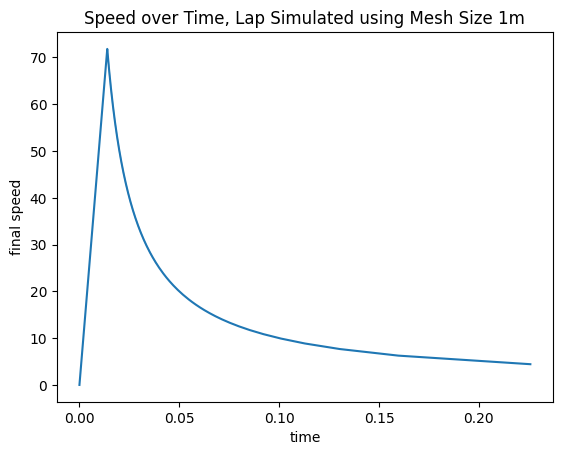

In [204]:
sns.lineplot(data=simulation_1m, x='time', y='final speed')
plt.title("Speed over Time, Lap Simulated using Mesh Size 1m")